[-10.9009626  -19.85385285  -5.10846278   4.34555078] [-10.9009626  -19.85385285  -5.10846278   4.34555078]


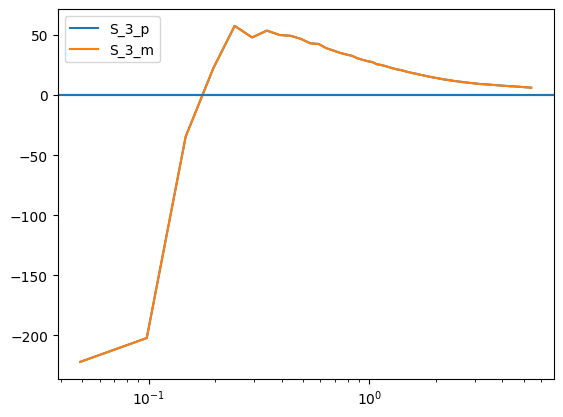

In [3]:
Mydatatype = "floatNred"
from numba import cuda, float64, int32
import numpy as np
import matplotlib.pyplot as plt
import math
import h5py as hp

TPB = (8,8,8)
##CUDA kernel
@cuda.jit
def structfn(N, zpx, zpy, zpz, zmx, zmy, zmz, sf_p, sf_m):

    (i,j,k) = cuda.grid(3)
  
    zpx_loc = zpx[i,j,k]
    zpy_loc = zpy[i,j,k]
    zpz_loc = zpz[i,j,k]

    zmx_loc = zmx[i,j,k]
    zmy_loc = zmy[i,j,k]
    zmz_loc = zmz[i,j,k]
    cuda.syncthreads()
 
    for lx in range(N[0]//2):
        for ly in  range(N[1]//2):
            for lz in range(N[2]//2):
                l_norm = math.sqrt(lx**2+ ly**2+ lz**2)
                l_ind = int(math.ceil(l_norm))
                dzp_vec = (zpx[i+lx,j+ly,k+lz]- zpx_loc, zpy[i+lx,j+ly,k+lz]- zpy_loc, zpz[i+lx,j+ly,k+lz]- zpz_loc)
                dzm_vec = (zmx[i+lx,j+ly,k+lz]- zmx_loc, zmy[i+lx,j+ly,k+lz]- zmy_loc, zmz[i+lx,j+ly,k+lz]- zmz_loc) 

                if l_norm > 1e-5:
                    S3p_loc = (dzp_vec[0]**2+ dzp_vec[1]**2+ dzp_vec[2]**2)* \
                            (dzm_vec[0]*lx+ dzm_vec[1]*ly+ dzm_vec[2]*lz)/l_norm
                cuda.syncthreads()
                    
                cuda.atomic.add(sf_p, (0,l_ind), S3p_loc)
                cuda.syncthreads() 

                if l_norm > 1e-5:
                    S3m_loc = (dzm_vec[0]**2+ dzm_vec[1]**2+ dzm_vec[2]**2)* \
                            (dzp_vec[0]*lx+ dzp_vec[1]*ly+ dzp_vec[2]*lz)/l_norm
                cuda.syncthreads()

                cuda.atomic.add(sf_m, (0,l_ind), S3m_loc)
                cuda.syncthreads() 

                if l_norm > 1e-5:
                    dzp_dot_l = (dzp_vec[0]*lx+ dzp_vec[1]*ly+ dzp_vec[2]*lz)/l_norm
                cuda.syncthreads()

                for q in range(qmin,qmax+1):
                    cuda.atomic.add(sf_p, (q-qmin+1,l_ind), dzp_dot_l**q)                     
                cuda.syncthreads()

                if l_norm > 1e-5:
                    dzm_dot_l = (dzm_vec[0]*lx+ dzm_vec[1]*ly+ dzm_vec[2]*lz)/l_norm
                cuda.syncthreads()

                for q in range(qmin,qmax+1):
                    cuda.atomic.add(sf_m, (q-qmin+1,l_ind), dzm_dot_l**q)                     
                cuda.syncthreads()

### MAIN                

Nred = 128
N = (Nred, Nred,Nred)
#N = (Nred, Nred, Nred)
lmax = math.ceil(np.linalg.norm(N))//2
count = np.zeros(lmax, dtype=int)
qmin = 2
qmax = 5
Qdiff_p1 = qmax-qmin+2
sf_p = np.zeros((Qdiff_p1, lmax))
sf_m = np.zeros((Qdiff_p1, lmax))


for i in range(N[0]//2):
    for j in range(N[1]//2):
        for k in range(N[2]//2):
            vec = np.array([i,j,k])
            ind = int(math.ceil(np.linalg.norm(vec)))
            count[ind] += 1

'''
zpx = np.ones(N, dtype=Mydatatype)
zpy = np.ones(N, dtype=Mydatatype)
zpz = np.ones(N, dtype=Mydatatype)

zmx = np.ones(N, dtype=Mydatatype)
zmy = np.ones(N, dtype=Mydatatype)
zmz = np.ones(N, dtype=Mydatatype)


dx = dy = dz = 1
for i in range(N[0]):
    for j in range(N[1]):
        for k in range(N[2]):
            zpx[i,j,k] = zmx[i,j,k] = i*dx
            zpy[i,j,k] = zmy[i,j,k] = j*dy
            zpz[i,j,k] = zmz[i,j,k] = k*dz
'''            

File_handle = hp.File("/home/mkv/MHD_data/3D/256_cube/field_50..h5",'r')
zpx = np.fft.irfft2(np.asarray(File_handle["zpkx"]))*N[0]*N[1]*N[2]
zpy = np.fft.irfft2(np.asarray(File_handle["zpky"]))*N[0]*N[1]*N[2]
zpz = np.fft.irfft2(np.asarray(File_handle["zpkz"]))*N[0]*N[1]*N[2]

zmx = np.fft.irfft2(np.asarray(File_handle["zmkx"]))*N[0]*N[1]*N[2]
zmy = np.fft.irfft2(np.asarray(File_handle["zmky"]))*N[0]*N[1]*N[2]
zmz = np.fft.irfft2(np.asarray(File_handle["zmkz"]))*N[0]*N[1]*N[2]

zpx = zpx[0:Nred]
zpy = zpx[0:Nred]
zpz = zpx[0:Nred]

zmx = zpx[0:Nred]
zmy = zpx[0:Nred]
zmz = zpx[0:Nred]

dx = dy = dz = 2*np.pi/N[0]

xforsf = np.arange(lmax)*dx

import math
BPG_x = math.ceil(N[0]/(2*TPB[0]))
BPG_y = math.ceil(N[1]/(2*TPB[0]))
BPG_z = math.ceil(N[2]/(2*TPB[0]))
BPG = (BPG_x, BPG_y, BPG_z)

zpx_global_mem = cuda.to_device(zpx)
zpy_global_mem = cuda.to_device(zpy)
zpz_global_mem = cuda.to_device(zpz)

zmx_global_mem = cuda.to_device(zmx)
zmy_global_mem = cuda.to_device(zmy)
zmz_global_mem = cuda.to_device(zmz)

sf_p_global_mem = cuda.to_device(sf_p)
sf_m_global_mem = cuda.to_device(sf_m)

#start the kernel
structfn[BPG,TPB](N, zpx_global_mem, zpy_global_mem, zpz_global_mem, zmx_global_mem,  zmy_global_mem, zmz_global_mem, \
                    sf_p_global_mem, sf_m_global_mem)


sf_p = sf_p_global_mem.copy_to_host()
sf_m = sf_m_global_mem.copy_to_host()

factor = N[0]*N[1]*N[2]/8
for l_loop in range(lmax):
    sf_p[:,l_loop] /=  (factor*count[l_loop])
    sf_m[:,l_loop] /=  (factor*count[l_loop])


plt.figure()
plt.semilogx(xforsf[1:], sf_p[0,1:]/xforsf[1:], label='S_3_p')
plt.semilogx(xforsf[1:], sf_m[0,1:]/xforsf[1:], label='S_3_m')
plt.axhline(y=0)
plt.axhline(y=0.1)

'''
for q in range(qmin,qmax+1):
    plt.loglog(xforsf[1:], sf_p[q-qmin+1,1:], label='$q = %i$' %q)
    plt.loglog(xforsf[1:], sf_m[q-qmin+1,1:], label='$q = %i$' %q)
'''
plt.legend(loc = 'upper left')
plt.savefig('numba2_new_MHD.png')

print( sf_p[0,1:5],  sf_m[0,1:5])


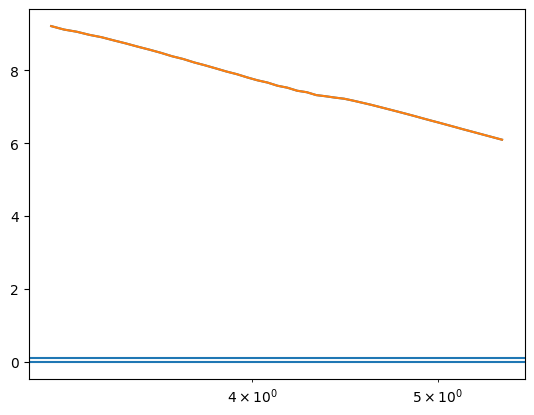

In [4]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
plt.semilogx(xforsf[64:], sf_p[0,64:]/xforsf[64:], label='S_3_p')
plt.semilogx(xforsf[64:], sf_m[0,64:]/xforsf[64:], label='S_3_m')
plt.axhline(y=0)
plt.axhline(y=0.1)

In [17]:
import numpy as np
from numba import cuda
import numpy
import math

# CUDA kernel
@cuda.jit
def matmul(A):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    (bx,by) = (cuda.blockIdx.x, cuda.blockIdx.y)
    local_r = (cuda.threadIdx.x, cuda.threadIdx.y)

    thread_id = threadsperblock[1]*cuda.threadIdx.x + cuda.threadIdx.y
    print("thread_id ",bx, by,thread_id, A[row, col])
    # if row < A.shape[0] and col < A.shape[1]:
    #     print(bx, by, local_r[0], local_r[1], row, col, A[row, col])

    #print(bx, by, local_r[0], local_r[1], ind, row)


N = (8,4)
# Initialize the data arrays
A = numpy.zeros(N) # matrix containing all 3's

A = np.arange(32).reshape(8,4)
print(A)

# Copy the arrays to the device
A_global_mem = cuda.to_device(A)

# Configure the blocks
threadsperblock = (4, 2)
blockspergrid_x = int(math.ceil(A.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(A.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

#print("blockspergrid = ", blockspergrid)
# Start the kernel
matmul[blockspergrid, threadsperblock](A_global_mem)

# Copy the result back to the host
A = A_global_mem.copy_to_host()


[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]
 [20 21 22 23]
 [24 25 26 27]
 [28 29 30 31]]
thread_id  0 1 0 2
thread_id  0 1 2 6
thread_id  0 1 4 10
thread_id  0 1 6 14
thread_id  0 1 1 3
thread_id  0 1 3 7
thread_id  0 1 5 11
thread_id  0 1 7 15
thread_id  1 1 0 18
thread_id  1 1 2 22
thread_id  1 1 4 26
thread_id  1 1 6 30
thread_id  1 1 1 19
thread_id  1 1 3 23
thread_id  1 1 5 27
thread_id  1 1 7 31
thread_id  1 0 0 16
thread_id  1 0 2 20
thread_id  1 0 4 24
thread_id  1 0 6 28
thread_id  1 0 1 17
thread_id  1 0 3 21
thread_id  1 0 5 25
thread_id  1 0 7 29
thread_id  0 0 0 0
thread_id  0 0 2 4
thread_id  0 0 4 8
thread_id  0 0 6 12
thread_id  0 0 1 1
thread_id  0 0 3 5
thread_id  0 0 5 9
thread_id  0 0 7 13


/home/mkv/.local/lib/python3.8/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [14]:
Mydatatype = "float64"
from numba import cuda, float64, int32
import numpy as np
import matplotlib.pyplot as plt
import math
import time


TPB = (16,16)
TPB2 = (TPB[0]*2, TPB[1]*2)  # double elements along each dirn, for u'
normalization_const =  TPB[0]*TPB[1]
##CUDA kernel
@cuda.jit
def structfn(ux, sf):

    local_result = cuda.shared.array(shape = 1, dtype=Mydatatype)

    local_r = (cuda.threadIdx.x, cuda.threadIdx.y) #(x,y) in C
    block_id = (cuda.blockIdx.x, cuda.blockIdx.y)
    global_r = (cuda.blockIdx.x*TPB[0]+cuda.threadIdx.x, \
              cuda.blockIdx.y*TPB[1]+cuda.threadIdx.y)
    thread_id = TPB[1]*cuda.threadIdx.x + cuda.threadIdx.y

    if (global_r == (0,0)):
        for q_ind in range(Qdiff_p1):
            for l_loop in range(lmax):
                sf[q_ind, l_loop] = 0.0
              #  print("init sf   = ( ",  q_ind, l_loop, sf[q_ind, l_loop] )
    cuda.syncthreads()

    if (global_r == (0,0)):
            print("sf_local   = ( ",     sf[1,1], sf[0,1])

   # block_gap = np.zeros(2, dtype=int)
    block_gap = cuda.local.array(2, dtype=int32)

    if (global_r == (0,0)):
            print("sf_local   = ( ",   block_id[0], block_id[1],   sf[1,1], sf[0,1])

    for bpx_id in range(block_id[0],block_id[0]+BPG[0]):
        for bpy_id in range(block_id[1],block_id[1]+BPG[1]):
            block_gap[0] = bpx_id - block_id[0]
            block_gap[1] = bpy_id - block_id[1]
            if (global_r == (0,0)):
                    print("-1 Before loop  = ( ",  block_id[0], block_id[1],  sf[1,1])


            # if (local_r == (0,0)):
            #     print("bid = ", bpx_id, bpy_id

            if (global_r == (0,0)):
                    print("0 Before loop  = ( ", block_id[0], block_id[1],    sf[1,1])

            for local_lx in range(TPB[0]):
              for local_ly in range(TPB[1]):
                l = (local_lx + block_gap[0]*TPB[0], local_ly + block_gap[1]*TPB[1])
                l_norm = math.sqrt(l[0]**2+l[1]**2)
                l_ind = int(math.ceil(l_norm))
                local_r_uprime = (cuda.threadIdx.x+local_lx, cuda.threadIdx.y+local_ly)
                cuda.syncthreads()

               # cuda.atomic.add(sf, (1 ,l_ind), dux[local_r]**2)
                if (global_r == (0,0)) and l_ind==1:
                    print("sf_local in loop 0 BEFORE = ( ",  local_lx, local_ly, ")",  \
                                  block_id[0], block_id[1],   sf[1,l_ind])
                cuda.atomic.add(sf, (1 ,l_ind), 1)
                cuda.syncthreads() 
                if (global_r == (0,0)) and l_ind==1:
                    print("sf_local in loop AFTER  = ( ",  local_lx, local_ly, ")",  \
                                     block_id[0], block_id[1],   sf[1,l_ind])
            cuda.syncthreads()     
   

#### END OF Kernel

def vel_field(N, dx, dy, ux):
    for i in range(N[0]):
        for j in range(N[1]):
            x = i*dx; y = j*dy 
            ux[i,j] = x
       #     ux[i,j] = np.sin(x)*np.cos(y)

# MAIN
#cuda.select_device(0)  # Select the first GPU
#device = cuda.current_context().device
#print(f"Using GPU: {device.name}")
#print(f"Total shared memory per block: {device.MAX_SHARED_MEMORY_PER_BLOCK}")

N = (64,64)
lmax = math.ceil(np.linalg.norm(N))//2
count = np.zeros(lmax, dtype=int)
qmin = 2
qmax = 2
Qdiff_p1 = qmax-qmin+2
sf = np.zeros(lmax))

for i in range(N[0]//2):
    for j in range(N[1]//2):
        vec = np.array([i,j])
        ind = int(math.ceil(np.linalg.norm(vec)))
        count[ind] += 1
#        print("count ", i, j, ind, count[ind])

ux = np.ones(N, dtype=Mydatatype)

dx = dy = 1 #2*np.pi/N[0]
vel_field(N, dx, dy, ux)
xforsf = np.arange(lmax)*dx

import math
BPG_x = math.ceil(N[0]/(2*TPB[0]))
BPG_y = math.ceil(N[1]/(2*TPB[1]))
BPG = (BPG_x, BPG_y)
print(BPG)

#global_counter = cuda.to_device(np.array([0], dtype=np.int32))
#Copy the arrays to the device
ux_global_mem = cuda.to_device(ux)
sf_global_mem = cuda.to_device(sf)
#start the kernel
structfn[BPG,TPB](ux_global_mem, sf_global_mem)
cuda.synchronize()

# Copy the result back to the host
sf = sf_global_mem.copy_to_host()

for l_loop in range(lmax):
    sf[:,l_loop] /=  1 #(BPG[0]*BPG[1]*count[l_loop])

'''
plt.figure()
plt.plot(xforsf[1:], -0.5*sf[0,1:]/xforsf[1:], label='S_3p')
plt.axhline(y=0)
plt.axhline(y=0.1)
# for q in range(qmin,qmax+1):
#     plt.loglog(xforsf[1:], sf_p[q-qmin+1,1:], label='$q = %i$' %q)
#     plt.loglog(xforsf[1:], sf_m[q-qmin+1,1:], label='$q = %i$' %q)


plt.figure()
#plt.loglog(xforsf[1:], sf[0,1:], label='S_3')
for q in range(qmin,qmax+1):
    plt.loglog(xforsf[1:], sf[q-qmin+1,1:], label='$q = %i$' %q)
'''
time.sleep(1)
print(sf[1:5])
#print(sf_test)
#plt.legend(loc = 'upper left')
#plt.savefig('numba2.png')


(2, 2)


/home/mkv/.local/lib/python3.8/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


sf_local   = (  0.000000 0.000000
sf_local   = (  0 0 1536.000000 0.000000
-1 Before loop  = (  0 0 1536.000000
0 Before loop  = (  0 0 1536.000000
sf_local in loop 0 BEFORE = (  0 1 ) 0 0 1536.000000
sf_local in loop AFTER  = (  0 1 ) 0 0 1792.000000
sf_local in loop 0 BEFORE = (  1 0 ) 0 0 1792.000000
sf_local in loop AFTER  = (  1 0 ) 0 0 2048.000000
-1 Before loop  = (  0 0 2048.000000
0 Before loop  = (  0 0 2048.000000
-1 Before loop  = (  0 0 2048.000000
0 Before loop  = (  0 0 2048.000000
-1 Before loop  = (  0 0 2048.000000
0 Before loop  = (  0 0 2048.000000
[[   0.    0.    0.    0.]
 [2048. 3072. 5120. 6144.]]


In [ ]:
Mydatatype = "float64"
from numba import cuda, float64, int32
import numpy as np
import matplotlib.pyplot as plt
import math
import time


TPB = (16,16)
TPB2 = (TPB[0]*2, TPB[1]*2)  # double elements along each dirn, for u'
normalization_const =  TPB[0]*TPB[1]
##CUDA kernel
@cuda.jit
def structfn(ux, sf):

    local_result = cuda.shared.array(shape = 1, dtype=Mydatatype)

    local_r = (cuda.threadIdx.x, cuda.threadIdx.y) #(x,y) in C
    block_id = (cuda.blockIdx.x, cuda.blockIdx.y)
    global_r = (cuda.blockIdx.x*TPB[0]+cuda.threadIdx.x, \
              cuda.blockIdx.y*TPB[1]+cuda.threadIdx.y)
    thread_id = TPB[1]*cuda.threadIdx.x + cuda.threadIdx.y


    if (global_r == (0,0)):
         for l_loop in range(lmax):
            print("init sf   = ( ", l_loop, sf[l_loop] )
    cuda.syncthreads()

    if (global_r == (0,0)):
            print("sf_local   = ( ",     sf[1])

   # block_gap = np.zeros(2, dtype=int)
    block_gap = cuda.local.array(2, dtype=int32)

    if (global_r == (0,0)):
            print("sf_local   = ( ",   block_id[0], block_id[1],   sf[1])

    for bpx_id in range(block_id[0],block_id[0]+BPG[0]):
        for bpy_id in range(block_id[1],block_id[1]+BPG[1]):
            block_gap[0] = bpx_id - block_id[0]
            block_gap[1] = bpy_id - block_id[1]
            if (global_r == (0,0)):
                    print("-1 Before loop  = ( ",  block_id[0], block_id[1],  sf[1])

            if (global_r == (0,0)):
                    print("0 Before loop  = ( ", block_id[0], block_id[1],    sf[1])

            for local_lx in range(TPB[0]):
              for local_ly in range(TPB[1]):
                l = (local_lx + block_gap[0]*TPB[0], local_ly + block_gap[1]*TPB[1])
                l_norm = math.sqrt(l[0]**2+l[1]**2)
                l_ind = int(math.ceil(l_norm))
                local_r_uprime = (cuda.threadIdx.x+local_lx, cuda.threadIdx.y+local_ly)
                cuda.syncthreads()

               # cuda.atomic.add(sf, (1 ,l_ind), dux[local_r]**2)
                if (global_r == (0,0)) and l_ind==1:
                    print("sf_local in loop 0 BEFORE = ( ",  local_lx, local_ly, ")",  \
                                  block_id[0], block_id[1],   bpx_id, bpy_id, sf[l_ind])
                cuda.atomic.add(sf, (l_ind), 1)
                cuda.syncthreads() 
                if (global_r == (0,0)) and l_ind==1:
                    print("sf_local in loop AFTER  = ( ",  local_lx, local_ly, ")",  \
                                     block_id[0], block_id[1], bpx_id, bpy_id,  sf[l_ind])
            cuda.syncthreads()     
   

#### END OF Kernel

def vel_field(N, dx, dy, ux):
    for i in range(N[0]):
        for j in range(N[1]):
            x = i*dx; y = j*dy 
            ux[i,j] = x
       #     ux[i,j] = np.sin(x)*np.cos(y)

# MAIN
#cuda.select_device(0)  # Select the first GPU
#device = cuda.current_context().device
#print(f"Using GPU: {device.name}")
#print(f"Total shared memory per block: {device.MAX_SHARED_MEMORY_PER_BLOCK}")

N = (64,64)
lmax = math.ceil(np.linalg.norm(N))//2
count = np.zeros(lmax, dtype=int)
qmin = 2
qmax = 2
Qdiff_p1 = qmax-qmin+2
sf = np.zeros(lmax)

for i in range(N[0]//2):
    for j in range(N[1]//2):
        vec = np.array([i,j])
        ind = int(math.ceil(np.linalg.norm(vec)))
        count[ind] += 1
#        print("count ", i, j, ind, count[ind])

ux = np.ones(N, dtype=Mydatatype)

dx = dy = 1 #2*np.pi/N[0]
vel_field(N, dx, dy, ux)
xforsf = np.arange(lmax)*dx

import math
BPG_x = math.ceil(N[0]/(2*TPB[0]))
BPG_y = math.ceil(N[1]/(2*TPB[1]))
BPG = (BPG_x, BPG_y)
print(BPG)

#global_counter = cuda.to_device(np.array([0], dtype=np.int32))
#Copy the arrays to the device
ux_global_mem = cuda.to_device(ux)
sf_global_mem = cuda.to_device(sf)
#start the kernel
structfn[BPG,TPB](ux_global_mem, sf_global_mem)
cuda.synchronize()

# Copy the result back to the host
sf = sf_global_mem.copy_to_host()

for l_loop in range(lmax):
    sf[l_loop] /=  1 #(BPG[0]*BPG[1]*count[l_loop])

'''
plt.figure()
plt.plot(xforsf[1:], -0.5*sf[0,1:]/xforsf[1:], label='S_3p')
plt.axhline(y=0)
plt.axhline(y=0.1)
# for q in range(qmin,qmax+1):
#     plt.loglog(xforsf[1:], sf_p[q-qmin+1,1:], label='$q = %i$' %q)
#     plt.loglog(xforsf[1:], sf_m[q-qmin+1,1:], label='$q = %i$' %q)


plt.figure()
#plt.loglog(xforsf[1:], sf[0,1:], label='S_3')
for q in range(qmin,qmax+1):
    plt.loglog(xforsf[1:], sf[q-qmin+1,1:], label='$q = %i$' %q)
'''
time.sleep(1)
print(sf[1:5])
#print(sf_test)
#plt.legend(loc = 'upper left')
#plt.savefig('numba2.png')


(32, 32)
sf_local  0 =   0 0 0.000000
[[      0.       0.       0.       0.]
 [ 524288.  786432. 1310720. 1572864.]]


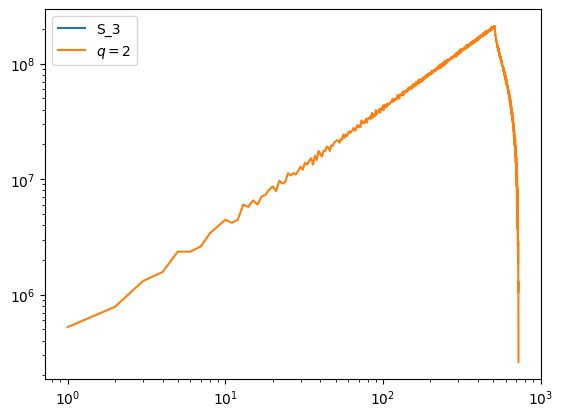

In [65]:
Mydatatype = "float64"
from numba import cuda, float64, int32
import numpy as np
import matplotlib.pyplot as plt
import math
import h5py as hp
import time 

TPB = (16,16)
##CUDA kernel
@cuda.jit
def structfn(N, ux, sf):

    (i,j) = cuda.grid(2)
    local_r = (cuda.threadIdx.x, cuda.threadIdx.y)
    global_r = (cuda.blockIdx.x*TPB[0]+cuda.threadIdx.x, \
              cuda.blockIdx.y*TPB[1]+cuda.threadIdx.y)
    block_id = (cuda.blockIdx.x, cuda.blockIdx.y)

    thread_id = TPB[1]*cuda.threadIdx.x + cuda.threadIdx.y
    
    if (global_r == (0,0)):
            print("sf_local  0 =  ",   block_id[0], block_id[1],    sf[1,1])
    cuda.syncthreads()

    ux_loc = ux[i,j]
    cuda.syncthreads()
 
    block_gap = cuda.local.array(2, dtype=int32)
    cuda.syncthreads()

    # if (local_r == (0,0)):
    #         print("sf_local 1  = ( ",   block_id[0], block_id[1],   sf[1,1])
    # cuda.syncthreads()

    for bpx_id in range(block_id[0],block_id[0]+BPG[0]):
        for bpy_id in range(block_id[1],block_id[1]+BPG[1]):
            block_gap[0] = bpx_id - block_id[0]
            block_gap[1] = bpy_id - block_id[1]
            cuda.syncthreads()
            # if (local_r == (0,0)):
            #         print("-1 Before loop  = ( ",  block_id[0], block_id[1],  sf[1,1])
            
            for local_lx in range(TPB[0]):
              for local_ly in range(TPB[1]):
                l = (local_lx + block_gap[0]*TPB[0], local_ly + block_gap[1]*TPB[1])
                l_norm = math.sqrt(l[0]**2+l[1]**2)
                l_ind = int(math.ceil(l_norm))
                cuda.syncthreads()
                
                # if (local_r == (0,0)) and l_ind==1:
                #     print(block_id[0], block_id[1], "sf_local in loop 0 BEFORE = ( ",  local_lx, local_ly, ")",  \
                #                      bpx_id, bpy_id, sf[1,l_ind])
                # cuda.syncthreads()     
                cuda.atomic.add(sf, (1,l_ind), 1)
                cuda.syncthreads() 
                # if (local_r == (0,0)) and l_ind==1:
                #     print(block_id[0], block_id[1], "sf_local in loop AFTER  = ( ",  local_lx, local_ly, ")",  \
                #                       bpx_id, bpy_id,  sf[1,l_ind])
                # cuda.syncthreads()     
                        
            #cuda.syncthreads()      
            

def vel_field(N, dx, dy, ux):
    for i in range(N[0]):
        for j in range(N[1]):
            x = i*dx; y = j*dy 
            ux[i,j] = x
       #     ux[i,j] = np.sin(x)*np.cos(y)
        
### MAIN
N = (1024, 1024)
Nby2 = (N[0]//2, N[1]//2)
lmax = math.ceil(np.linalg.norm(N))//2
count = np.zeros(lmax, dtype=int)
qmin = 2
qmax = 2
Qdiff_p1 = qmax-qmin+2
sf = np.zeros((Qdiff_p1, lmax), dtype=Mydatatype)

for i in range(N[0]//2):
    for j in range(N[1]//2):
        vec = np.array([i,j])
        ind = int(math.ceil(np.linalg.norm(vec)))
        count[ind] += 1

ux = np.ones(N, dtype=Mydatatype)

dx = dy = 1 #2*np.pi/N[0]
vel_field(N, dx, dy, ux)

xforsf = np.arange(lmax)*dx


import math
BPG_x = math.ceil(N[0]/(2*TPB[0]))
BPG_y = math.ceil(N[1]/(2*TPB[0]))
BPG = (BPG_x, BPG_y)
print(BPG)
#Copy the arrays to the device
ux_global_mem = cuda.to_device(ux)
sf_global_mem = cuda.to_device(sf)

#start the kernel
structfn[BPG,TPB](N, ux_global_mem, sf_global_mem)
cuda.synchronize()

# Copy the result back to the host
sf = sf_global_mem.copy_to_host()

factor = N[0]*N[1]/4
for l_loop in range(lmax):
    sf[:,l_loop] /=  1 #(factor*count[l_loop])

plt.figure()
plt.loglog(xforsf[1:], -0.5*sf[0,1:]/xforsf[1:], label='S_3')
for q in range(qmin,qmax+1):
    plt.loglog(xforsf[1:], sf[q-qmin+1,1:], label='$q = %i$' %q)

plt.legend(loc = 'upper left')
#plt.savefig('numba2_py_hydro.png')
time.sleep(1)
print(sf[:,1:5])